# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
* Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
* Контролировать добросовестность кассиров при продаже алкоголя.

Необходимо построить модель, которая по фотографии определит приблизительный возраст человека. В распоряжении набор фотографий людей с указанием возраста. Данные взяты с сайта [ChaLearn Looking at People](http://chalearnlap.cvc.uab.es/dataset/26/description/).

MAE модели должно быть не больше 8 лет.

______

###### Данный проект разделен на несколько частей.

* [1. Исследовательский анализ данных.](#section1)
* [2. Обучение модели.](#section2)
* [3. Анализ обученной модели.](#section3)
* [4. Выводы.](#section4)

<a id='section1'> </a>

## Исследовательский анализ данных

In [1]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('/datasets/faces/labels.csv')
df.head(10)

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
5,000005.jpg,27
6,000006.jpg,24
7,000007.jpg,43
8,000008.jpg,26
9,000009.jpg,39


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


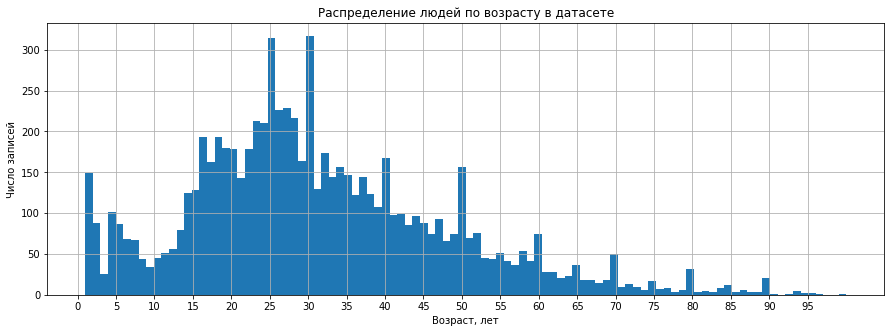

In [4]:
(df['real_age'].hist(bins=100, figsize=(15,5))
               .set(xlabel='Возраст, лет',
                    xticks=[x for x in range(0, 100, 5)],
                    ylabel='Число записей',
                    title='Распределение людей по возрасту в датасете'));

In [5]:
df['real_age'].describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

Все строки в данных заполнены, пропусков не выявлено. В данных представлены люди с возрастом от 1 до 100 лет. Все числа в столбце с возрастом целые (нет дробных). Медиана распределения (29 лет) близка к среднему (31,2 года). На гистограмме видна линейчатость (пики на "круглых" числах). Это может объяснятся тем, что целевой признак для датасета получен путем опроса людей, а люди склонны отвечать на заданные воросы "круглыми" числами.

In [6]:
BATCH_SIZE = 32

train_datagenerator = ImageDataGenerator(rescale=1/255.)
train_datagen_flow = train_datagenerator.flow_from_dataframe(dataframe=df,
                                                            directory='/datasets/faces/final_files/',
                                                            x_col='file_name',
                                                            y_col='real_age',
                                                            target_size=(224, 224),
                                                            batch_size=BATCH_SIZE,
                                                            class_mode='raw',
                                                            seed=42)

Found 7591 validated image filenames.


In [7]:
input_shape = train_datagen_flow[0][0][0].shape
input_shape

(224, 224, 3)

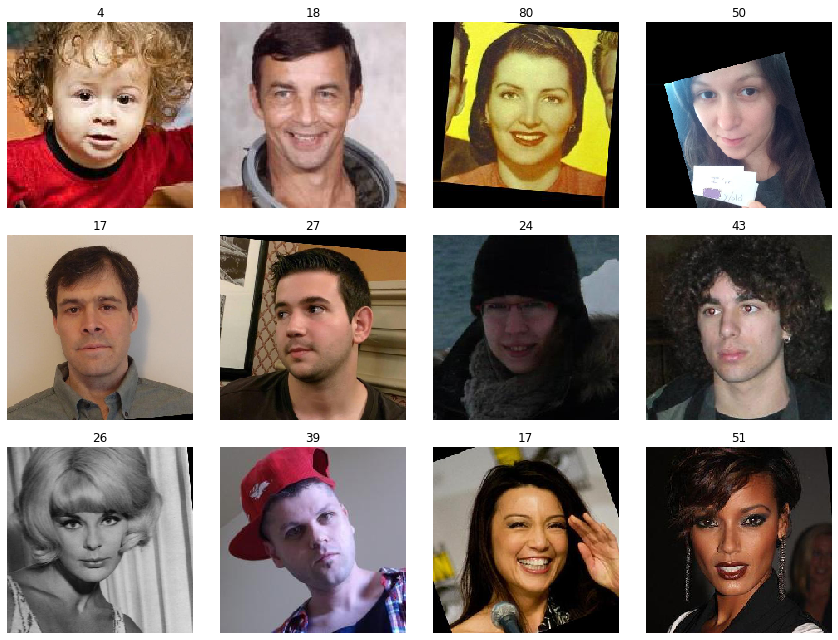

In [8]:
FIG_N_ROW = 3
FIG_N_COL = 4
BATCH_TO_PLOT = 0

_, axs = plt.subplots(FIG_N_ROW, FIG_N_COL, figsize=(FIG_N_COL * 3, FIG_N_ROW * 3))
axs = axs.flatten()

for i, ax in zip(range(FIG_N_ROW * FIG_N_COL), axs):
    ax.set_axis_off()
    ax.set_title(df.loc[i + BATCH_SIZE * BATCH_TO_PLOT, 'real_age'])
    ax.imshow(train_datagen_flow[BATCH_TO_PLOT][0][i])
plt.tight_layout()

**Выводы по разделу:**

1. Размер выборки (7591 изображение) можно считать достаточным для обучения. Однако учитывая, что размер выборки не очень большой лучше рассмотеть возможность использования предобученой сети.
2. В данных представлены люди с возрастом от 1 до 100 лет. Распределение целевого признака имеет линейчатую стуктуру (пики на "круглых" числах), что может быть обусловлено спецификой ответов людей.
3. В датасете представлены цветные фотогафии над которыми заранее поведены операции обрезки, масштабироваия и поворотов таким образом чтобы лица занимали большую площадь изобажения (см. [статью](http://people.ee.ethz.ch/~timofter/publications/Agustsson-FG-2017.pdf) авторов.)


<a id='section2'> </a>

## Обучение модели

Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке.

```python

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.losses import MeanSquaredError
import numpy as np
import pandas as pd


def load_train(path):
    df = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(rescale=1/255., validation_split=0.2)
    train_datagen_flow = train_datagen.flow_from_dataframe(dataframe=df,
                                                            directory=path + '/final_files/',
                                                            x_col='file_name',
                                                            y_col='real_age',
                                                            target_size=(224, 224),
                                                            batch_size=32,
                                                            class_mode='raw',
                                                            subset='training',
                                                            seed=42)
    return train_datagen_flow


def load_test(path):
    df = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(rescale=1/255., validation_split=0.2)
    test_datagen_flow = test_datagen.flow_from_dataframe(dataframe=df,
                                                            directory=path + '/final_files/',
                                                            x_col='file_name',
                                                            y_col='real_age',
                                                            target_size=(224, 224),
                                                            batch_size=32,
                                                            class_mode='raw',
                                                            subset='validation',
                                                            seed=42)
    return test_datagen_flow


def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)
    #backbone.trainable = False

    model = Sequential([
        backbone,
        GlobalAveragePooling2D(),
        Dense(1, activation='relu')
    ])
    
    optimizer = Adam(lr=0.0005)
    model.compile(optimizer=optimizer, loss=MeanSquaredError(),
                  metrics=['mae'])
    return model


def train_model(model, train_data, test_data, batch_size=32, epochs=25,
               steps_per_epoch=None, validation_steps=None):

    model.fit(train_data, 
              validation_data=(test_data),
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)
    return model 

```

```

2021-03-25 19:47:26.390078: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.6
2021-03-25 19:47:26.392332: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer_plugin.so.6
Using TensorFlow backend.
Found 6073 validated image filenames.
Found 1518 validated image filenames.
2021-03-25 19:47:27.509983: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-03-25 19:47:28.186859: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-PCIE-32GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2021-03-25 19:47:28.186937: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2021-03-25 19:47:28.186992: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-03-25 19:47:28.189020: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2021-03-25 19:47:28.189387: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2021-03-25 19:47:28.191700: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2021-03-25 19:47:28.193259: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2021-03-25 19:47:28.193320: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2021-03-25 19:47:28.196780: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2021-03-25 19:47:28.197177: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2021-03-25 19:47:28.204783: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 1999990000 Hz
2021-03-25 19:47:28.205454: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x53a6040 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-03-25 19:47:28.205479: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2021-03-25 19:47:28.336186: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x542c060 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2021-03-25 19:47:28.336226: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-PCIE-32GB, Compute Capability 7.0
2021-03-25 19:47:28.338285: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-PCIE-32GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2021-03-25 19:47:28.338353: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2021-03-25 19:47:28.338370: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-03-25 19:47:28.338405: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2021-03-25 19:47:28.338427: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2021-03-25 19:47:28.338446: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2021-03-25 19:47:28.338464: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2021-03-25 19:47:28.338477: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2021-03-25 19:47:28.342146: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2021-03-25 19:47:28.342203: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2021-03-25 19:47:28.687959: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1096] Device interconnect StreamExecutor with strength 1 edge matrix:
2021-03-25 19:47:28.688047: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1102]      0 
2021-03-25 19:47:28.688057: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] 0:   N 
2021-03-25 19:47:28.691638: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 30509 MB memory) -> physical GPU (device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:8b:00.0, compute capability: 7.0)
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 190 steps, validate for 48 steps
Epoch 1/25
2021-03-25 19:47:42.508912: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-03-25 19:47:42.830255: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
190/190 - 51s - loss: 193.6943 - mae: 10.4733 - val_loss: 289.2275 - val_mae: 12.9248
Epoch 2/25
190/190 - 40s - loss: 102.5378 - mae: 7.7258 - val_loss: 399.2067 - val_mae: 14.9068
Epoch 3/25
190/190 - 40s - loss: 65.1657 - mae: 6.1860 - val_loss: 480.4082 - val_mae: 16.6642
Epoch 4/25
190/190 - 40s - loss: 44.4135 - mae: 5.1511 - val_loss: 185.1641 - val_mae: 10.6552
Epoch 5/25
190/190 - 40s - loss: 30.1245 - mae: 4.2353 - val_loss: 94.2311 - val_mae: 7.2524
Epoch 6/25
190/190 - 40s - loss: 19.6878 - mae: 3.4216 - val_loss: 79.5876 - val_mae: 7.0508
Epoch 7/25
190/190 - 40s - loss: 11.7631 - mae: 2.6524 - val_loss: 86.4036 - val_mae: 7.2982
Epoch 8/25
190/190 - 40s - loss: 10.4048 - mae: 2.4632 - val_loss: 83.7626 - val_mae: 6.8221
Epoch 9/25
190/190 - 40s - loss: 9.0485 - mae: 2.3072 - val_loss: 77.0607 - val_mae: 6.6699
Epoch 10/25
190/190 - 40s - loss: 8.7250 - mae: 2.2572 - val_loss: 75.6013 - val_mae: 6.4736
Epoch 11/25
190/190 - 40s - loss: 9.6183 - mae: 2.3798 - val_loss: 83.1328 - val_mae: 7.3097
Epoch 12/25
190/190 - 40s - loss: 9.0659 - mae: 2.3149 - val_loss: 77.4212 - val_mae: 6.6601
Epoch 13/25
190/190 - 40s - loss: 8.6089 - mae: 2.2448 - val_loss: 72.7997 - val_mae: 6.6052
Epoch 14/25
190/190 - 40s - loss: 8.9256 - mae: 2.3018 - val_loss: 75.8676 - val_mae: 6.5288
Epoch 15/25
190/190 - 40s - loss: 8.7672 - mae: 2.2845 - val_loss: 72.3921 - val_mae: 6.4479
Epoch 16/25
190/190 - 40s - loss: 9.1517 - mae: 2.3177 - val_loss: 77.5885 - val_mae: 6.4143
Epoch 17/25
190/190 - 40s - loss: 9.3696 - mae: 2.3377 - val_loss: 71.9609 - val_mae: 6.3692
Epoch 18/25
190/190 - 40s - loss: 8.5886 - mae: 2.2279 - val_loss: 72.9026 - val_mae: 6.5319
Epoch 19/25
190/190 - 40s - loss: 9.0035 - mae: 2.2870 - val_loss: 76.6428 - val_mae: 6.6787
Epoch 20/25
190/190 - 40s - loss: 9.2249 - mae: 2.3176 - val_loss: 79.8050 - val_mae: 6.9660
Epoch 21/25
190/190 - 40s - loss: 10.5700 - mae: 2.4812 - val_loss: 97.5104 - val_mae: 7.4005
Epoch 22/25
190/190 - 40s - loss: 10.0630 - mae: 2.4293 - val_loss: 72.4514 - val_mae: 6.3833
Epoch 23/25
190/190 - 39s - loss: 8.5867 - mae: 2.2429 - val_loss: 77.5193 - val_mae: 6.6091
Epoch 24/25
190/190 - 40s - loss: 7.6198 - mae: 2.1057 - val_loss: 73.9274 - val_mae: 6.3086
Epoch 25/25
190/190 - 40s - loss: 6.5349 - mae: 1.9401 - val_loss: 66.7509 - val_mae: 6.1546
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
48/48 - 8s - loss: 66.7509 - mae: 6.1546
Test MAE: 6.1546

```

<a id='section3'> </a>

## Анализ обученной модели

In [9]:
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error

dummy_model = DummyRegressor(strategy='median')
dummy_model.fit([None] * len(df), df['real_age'])
print('MAE при предсказании медианой: {:.4f}'.format(mean_absolute_error(df['real_age'], 
                                                     dummy_model.predict([None] * len(df)))))

MAE при предсказании медианой: 13.1199


Полученная нейросетевая модель имеет MAE почти в два раза лучше, чем при предсказании медианой (6.15 года, против 13.12 у медианы)

<a id='section4'> </a>
## Выводы

В проекте была разработана нейросетевая модель для определения возраста покупателей на основе сети ResNet50. Нейросеть обучалась на данных в которых представлены люди возрастом от 1 до 100 лет. Медиана распределения - 29 лет. Cреднее распределения - 31,2 года.

Обученная модель показала среднюю абсолютную ошибку (MAE) на тестовой выборке 6,15 года, модель предсказывающая медиану распределения на тестовой выборке дала среднюю абсолютную ошибку 13,12 года, что говорит о работоспособности модели и возможности ее рассмотрения для далнейшего использования.

Необходимо отметить что MAE модели на тренировочной выборке (1,94) значительно ниже MAE модели на тестовой выборке (6,15), что может говорить о некотором перобучении модели. Необходимо доолнительно отслеживать качество модели в случае ее дальнейшего исользования.